# Try guided autoencoder

In [2]:
import os
import colorcet as cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from aging.behavior.syllables import relabel_by_usage
from torchmetrics.functional import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

## Load longtogeny

In [4]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7


def load_long_df(version=4):
    usage_mtx = pd.read_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean.parquet')
    return usage_mtx

In [3]:
df = load_long_df(version=5)

In [5]:
df.head()

relabeled_syllables                                                                         0   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.016502   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.007271   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.013241   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30 15:32:55  0.001998   
    02_02 02   567a1f13-cc44-478d-9547-bbe13f304592 02_02_021    2021-03-30 15:33:04  0.004022   

relabeled_syllables                                                                         1   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.025931   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.025691   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.035118   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30 15:32:55  0.010490   
    02_02 02   567a1f13-cc44-478d-9547-bbe13f304592 02_02_021    2021-03-30 15:33:04  0.012066   

relabeled_syllables                                                                         2   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.012730   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.015511   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.018423   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30 15:32:55  0.003497   
    02_02 02   567a1f13-cc44-478d-9547-bbe13f304592 02_02_021    2021-03-30 15:33:04  0.001508   

relabeled_syllables                                                                         3   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.002357   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.010179   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.002303   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30 15:32:55  0.000500   
    02_02 02   567a1f13-cc44-478d-9547-bbe13f304592 02_02_021    2021-03-30 15:33:04  0.001006   

relabeled_syllables                                                                         4   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.018859   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.031992   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.017271   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30 15:32:55  0.002997   
    02_02 02   567a1f13-cc44-478d-9547-bbe13f304592 02_02_021    2021-03-30 15:33:04  0.009553   

relabeled_syllables                                                                         5   \
age mouse cage uuid                                 subject_name date                            
21  01_01 01   2c031642-6e7a-4b1a-8b0c-eaa2f28ef089 01_01_021    2021-03-30 14:49:21  0.015087   
    01_02 01   181340b6-6c1d-4528-8920-2102d75d5711 01_02_021    2021-03-30 14:52:48  0.025206   
    01_04 01   b9459d2b-2357-427a-ad23-1b447a7621ea 01_04_021    2021-03-30 14:50:47  0.016120   
    02_01 02   b1884a07-9d38-44e7-916b-b2d6b4e0b985 02_01_021    2021-03-30

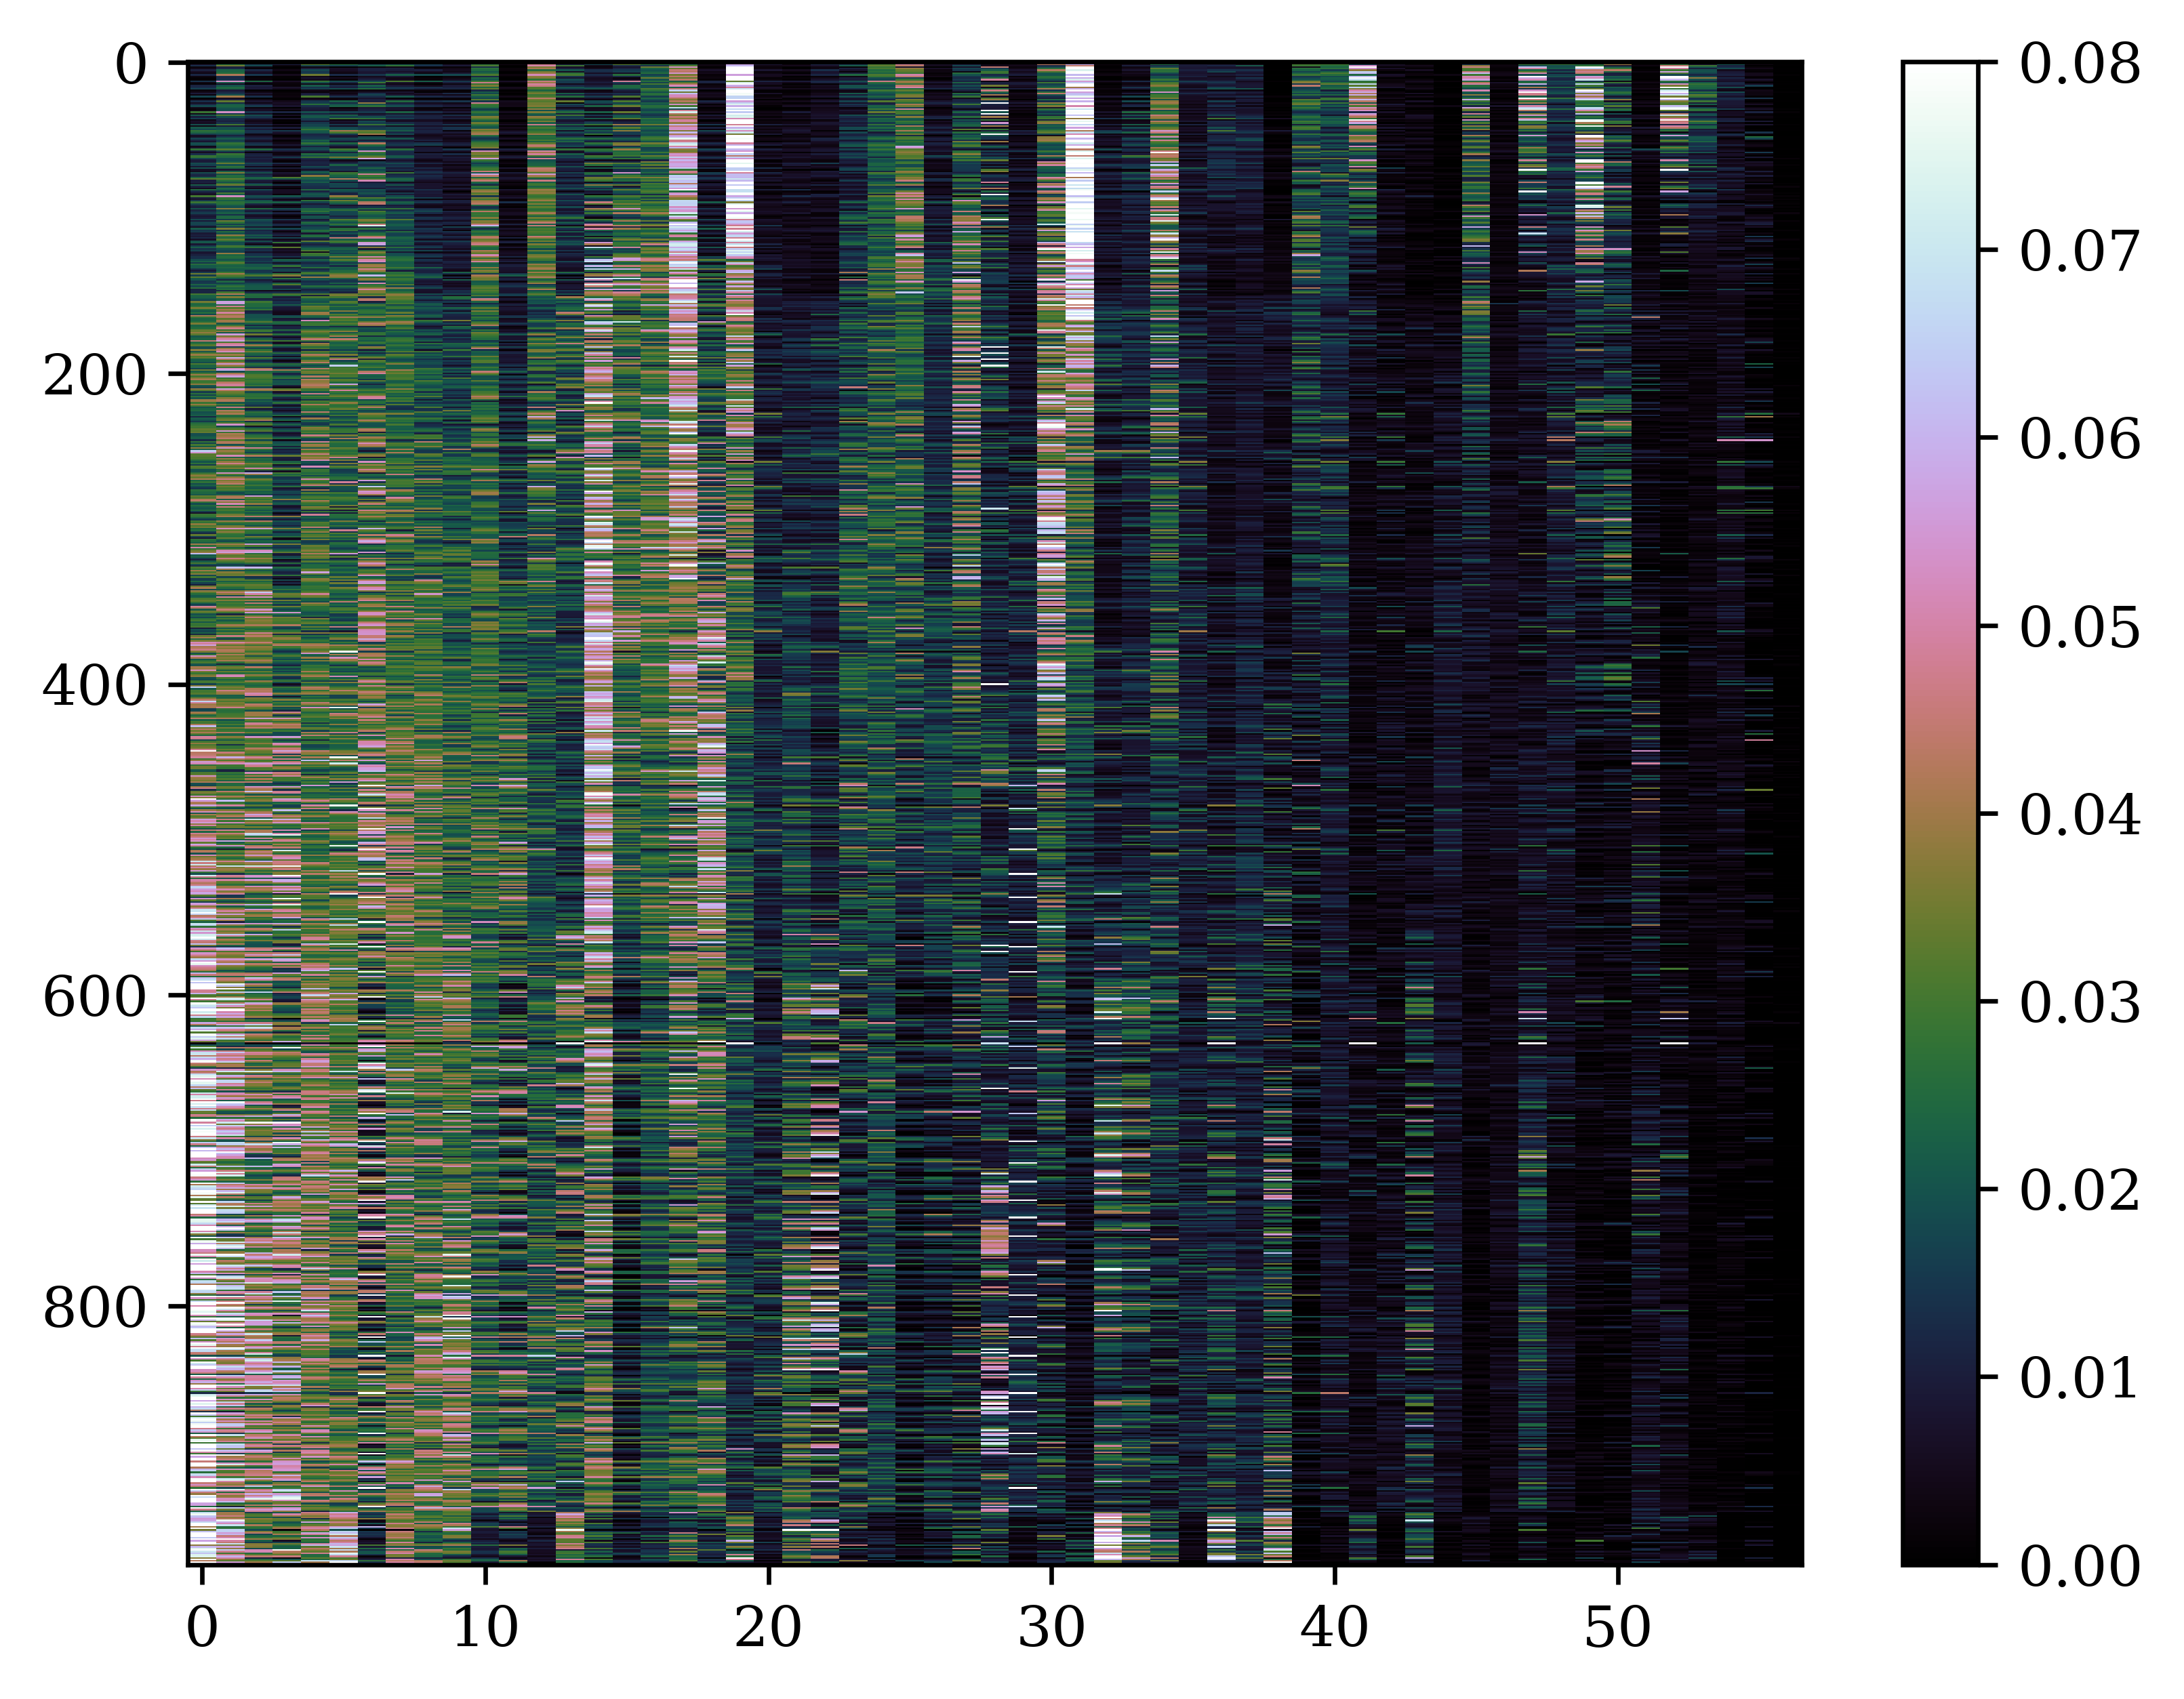

In [6]:
plt.imshow(df, aspect='auto', interpolation='none', vmax=0.08, cmap='cubehelix')
plt.colorbar()

In [6]:
class GuidedAE(nn.Module):
    def __init__(self, input_dims, activation, hidden_dims: list | tuple, latent_dim, mdl_type='regressor', n_classes=None):
        super().__init__()
        self.input_dims = input_dims
        self.n_layers = len(hidden_dims)
        self.hidden_dim = hidden_dims
        self.latent_dim = latent_dim
        if n_classes is None:
            n_classes = latent_dim

        layers = []
        for _in, _out in zip(hidden_dims, hidden_dims[1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(activation())

        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims[0]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[-1], latent_dim),
            # activation(),
        )

        layers = []
        for _in, _out in zip(hidden_dims[::-1], hidden_dims[::-1][1:]):
            layers.append(nn.Linear(_in, _out))
            layers.append(activation())

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[-1]),
            activation(),
            *layers,
            nn.Linear(hidden_dims[0], input_dims)
        )
        # linear regressor to predict age
        if mdl_type == 'regressor':
            self.lm = nn.Linear(latent_dim, 1)
        else:
            self.lm = nn.Linear(latent_dim, n_classes)

    def forward(self, x):
        latent = self.transform(x)
        return self.decoder(latent), self.lm(latent), latent

    def transform(self, x):
        return self.encoder(x)

    def predict(self, x):
        return self.lm(self.transform(x))

In [7]:
class AgeDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.age = data.index.get_level_values("age")
        # self.age = np.log(self.age)
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.age)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.age[idx], dtype=torch.float
        )


class MouseDataset(Dataset):
    def __init__(self, data: pd.DataFrame, log_xform: bool = False):
        self.mouse = data.index.get_level_values("mouse_id")
        self.mouse = LabelEncoder().fit_transform(self.mouse)
        self.syllables = data.to_numpy()
        if log_xform:
            self.syllables = np.log(self.syllables + 1e-6)

    def __len__(self):
        return len(self.mouse)

    def __getitem__(self, idx):
        return torch.tensor(self.syllables[idx], dtype=torch.float), torch.tensor(
            self.mouse[idx], dtype=torch.long
        )

In [8]:
class LitGAE(pl.LightningModule):
    def __init__(self, model, beta, data, batch_size=32, mdl_type='regressor'):
        super().__init__()
        self.model = model
        self.beta = beta
        self.data = data
        self.batch_size = batch_size
        self.mdl_type = mdl_type

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, _ = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == 'classifier':
            loss += (1 - self.beta) * F.cross_entropy(age_hat, age)
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        syllables, age = batch
        syllables_hat, age_hat, _ = self.model(syllables)
        loss = self.beta * F.mse_loss(syllables_hat, syllables)
        if self.mdl_type == 'classifier':
            loss += (1 - self.beta) * F.cross_entropy(age_hat, age)
        else:
            loss += (1 - self.beta) * F.mse_loss(age_hat.squeeze(), age)
        self.log("val_loss", loss, prog_bar=True)
        if self.mdl_type == 'classifier':
            self.log("acc", age_hat.argmax(dim=1).eq(age).float().mean(), prog_bar=True)
        else:
            self.log("r2", r2_score(age_hat, age.unsqueeze(1)), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-6)

    def setup(self, stage):
        kfold = StratifiedKFold(5)
        ex = self.data.sample(frac=1.0, random_state=0)
        bins = pd.qcut(ex.index.get_level_values('age'), 15, labels=False)
        for i, (train, test) in enumerate(kfold.split(ex, bins)):
            break
        train_d = ex.iloc[train]
        test_d = ex.iloc[test]
        if self.mdl_type == 'classifier':
            self.training_data = MouseDataset(train_d, log_xform=False)
            self.val_data = MouseDataset(test_d, log_xform=False)
        else:
            self.training_data = AgeDataset(train_d, log_xform=False)
            self.val_data = AgeDataset(test_d, log_xform=False)

    def train_dataloader(self):
        return DataLoader(
            self.training_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            num_workers=int(os.environ.get("SLURM_CPUS_PER_TASK", default=1)),
            shuffle=False,
        )

In [9]:
# mdl_type = 'classifier'
# n_mice = df.index.get_level_values('mouse_id').nunique()
# model = GuidedAE(len(df.columns), nn.Tanh, [128, 64, 32, 16, 8], latent_dim=2, mdl_type=mdl_type, n_classes=n_mice)
# gae = LitGAE(model, 0.01, df, batch_size=64, mdl_type=mdl_type)

# trainer = pl.Trainer(
#     max_epochs=100,
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     logger=False,
#     precision='16-mixed' if torch.cuda.is_available() else 'bf16-mixed',
#     enable_checkpointing=False,
#     enable_progress_bar=False
# )
# trainer.fit(gae)

In [10]:
# emb = model.transform(torch.tensor(np.log(df.to_numpy() + 1e-6), dtype=torch.float32)).detach().numpy()

In [11]:
# plt.scatter(*emb.T, c=df.index.get_level_values('age'))

In [12]:
# plt.scatter(emb[:, 0], df.index.get_level_values('age'))
# plt.scatter(emb[:, 1], np.log(df.index.get_level_values('age')))

In [13]:
import warnings

In [14]:
warnings.simplefilter('ignore')

In [15]:
def zscore(ser):
    return (ser - ser.mean()) / ser.std()

In [16]:
# in_df = df / df.max().max()
in_df = np.log(df + 1e-6)
in_df = in_df.transform(zscore, axis=1)
# in_df = zscore(in_df)
in_df.index = in_df.index.set_levels(zscore(pd.Series(in_df.index.levels[0])), level='age')

In [26]:
mdl_type = "regressor"

n_mice = in_df.index.get_level_values("mouse_id").nunique()

betas = [0.01, 0.1, 0.2, 0.5, 0.9, 0.99]

regressor_output = {}
for beta in tqdm(betas):
    model = GuidedAE(
        len(in_df.columns),
        nn.GELU,
        [32, 16, 8, 4],
        latent_dim=2,
        mdl_type=mdl_type,
        n_classes=n_mice,
    )
    gae = LitGAE(model, beta, in_df, batch_size=64, mdl_type=mdl_type)

    trainer = pl.Trainer(
        max_epochs=75,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=False,
        precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
        enable_checkpointing=False,
        enable_progress_bar=False,
    )
    trainer.fit(gae)

    print(beta)
    out = trainer.validate(gae)
    regressor_output[beta] = out

  0%|          | 0/6 [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.01


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8310141563415527     │
│         val_loss          │    0.16097037494182587    │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8337645530700684     │
│         val_loss          │    0.17485758662223816    │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8427221179008484     │
│         val_loss          │    0.18658435344696045    │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8323962688446045     │
│         val_loss          │    0.24627867341041565    │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.9


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8252955675125122     │
│         val_loss          │    0.28679078817367554    │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.99


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.7148241400718689     │
│         val_loss          │    0.2967401146888733     │
└───────────────────────────┴───────────────────────────┘

In [51]:
model = GuidedAE(
    len(in_df.columns),
    nn.GELU,
    [32, 16, 8, 4],
    latent_dim=2,
    mdl_type=mdl_type,
    n_classes=n_mice,
)
gae = LitGAE(model, 0.2, in_df, batch_size=64, mdl_type=mdl_type)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=False,
    precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
    enable_checkpointing=False,
    enable_progress_bar=False,
)
trainer.fit(gae)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=100` reached.


In [30]:
out = pd.DataFrame([x[0] for x in regressor_output.values()], index=list(regressor_output))

In [31]:
out

,val_loss,r2
0.01,0.160970,0.831014
0.10,0.174858,0.833765
0.20,0.186584,0.842722
0.50,0.246279,0.832396
0.90,0.286791,0.825296
0.99,0.296740,0.714824


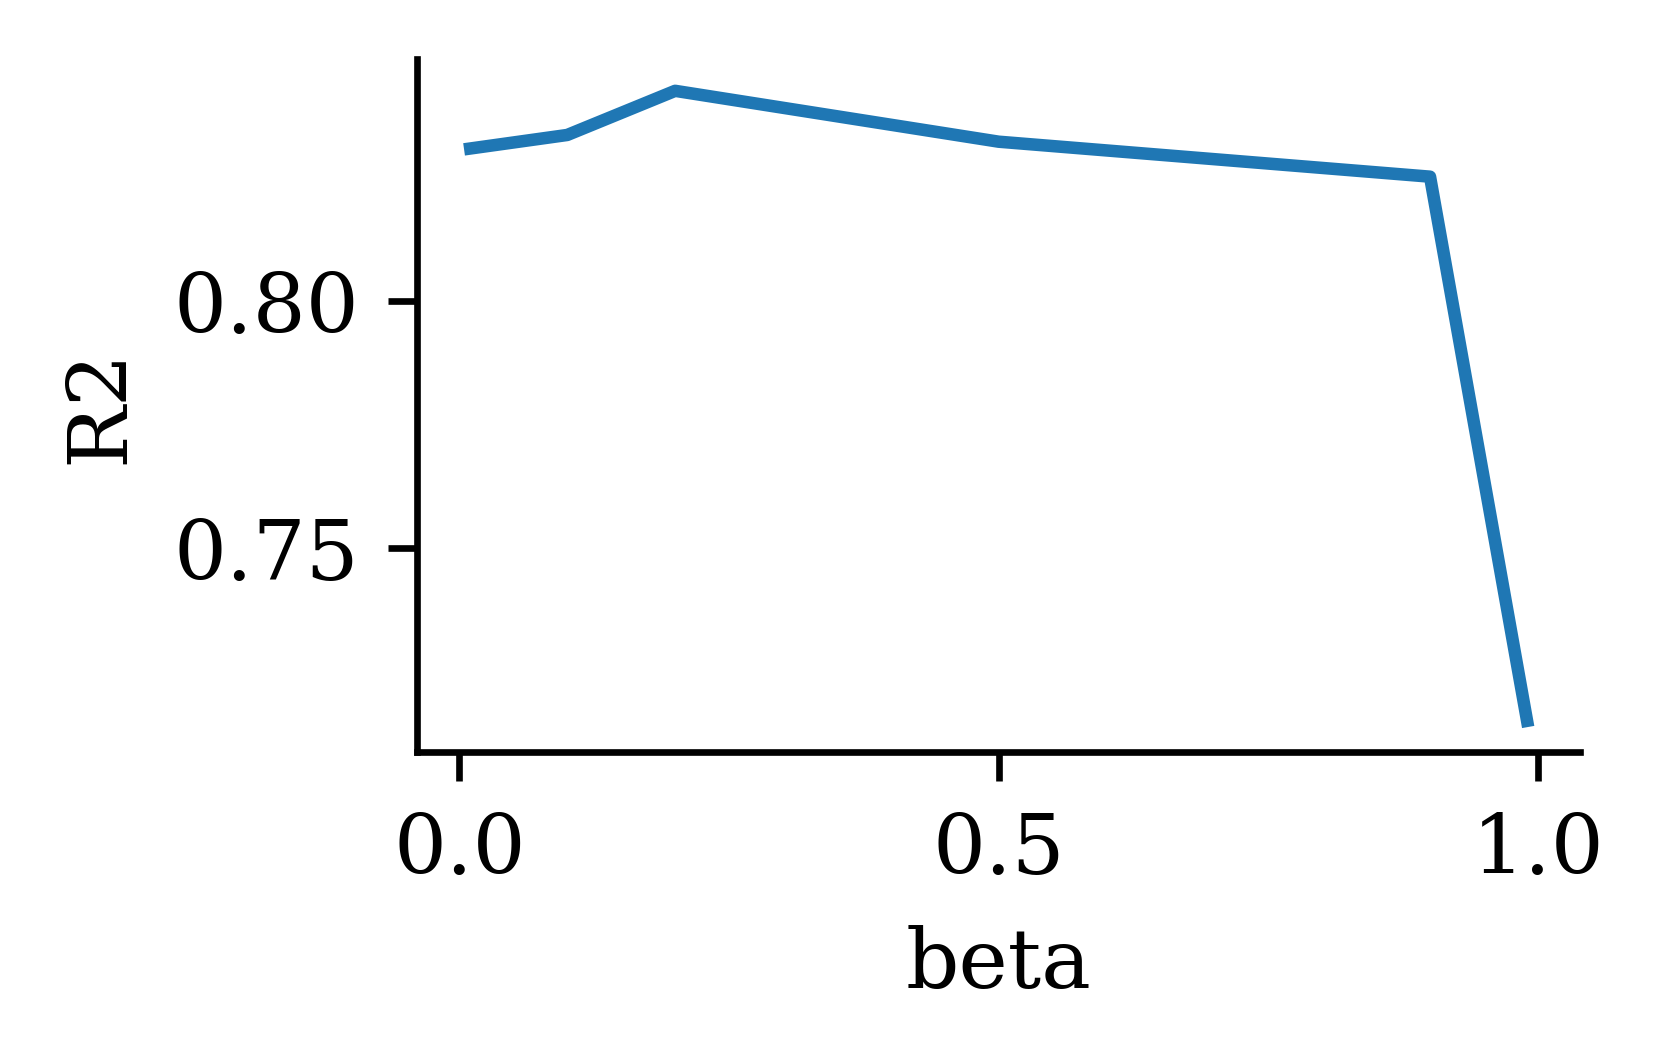

In [36]:
ax = out['r2'].plot(figsize=(2.5, 1.5))
ax.set(ylabel='R2', xlabel='beta')
sns.despine()

In [52]:
trainer.validate(gae)

SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            r2             │    0.8376469612121582     │
│         val_loss          │    0.1891353577375412     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.1891353577375412, 'r2': 0.8376469612121582}]

In [53]:
emb = model.transform(torch.tensor(in_df.to_numpy(), dtype=torch.float32)).detach().numpy()

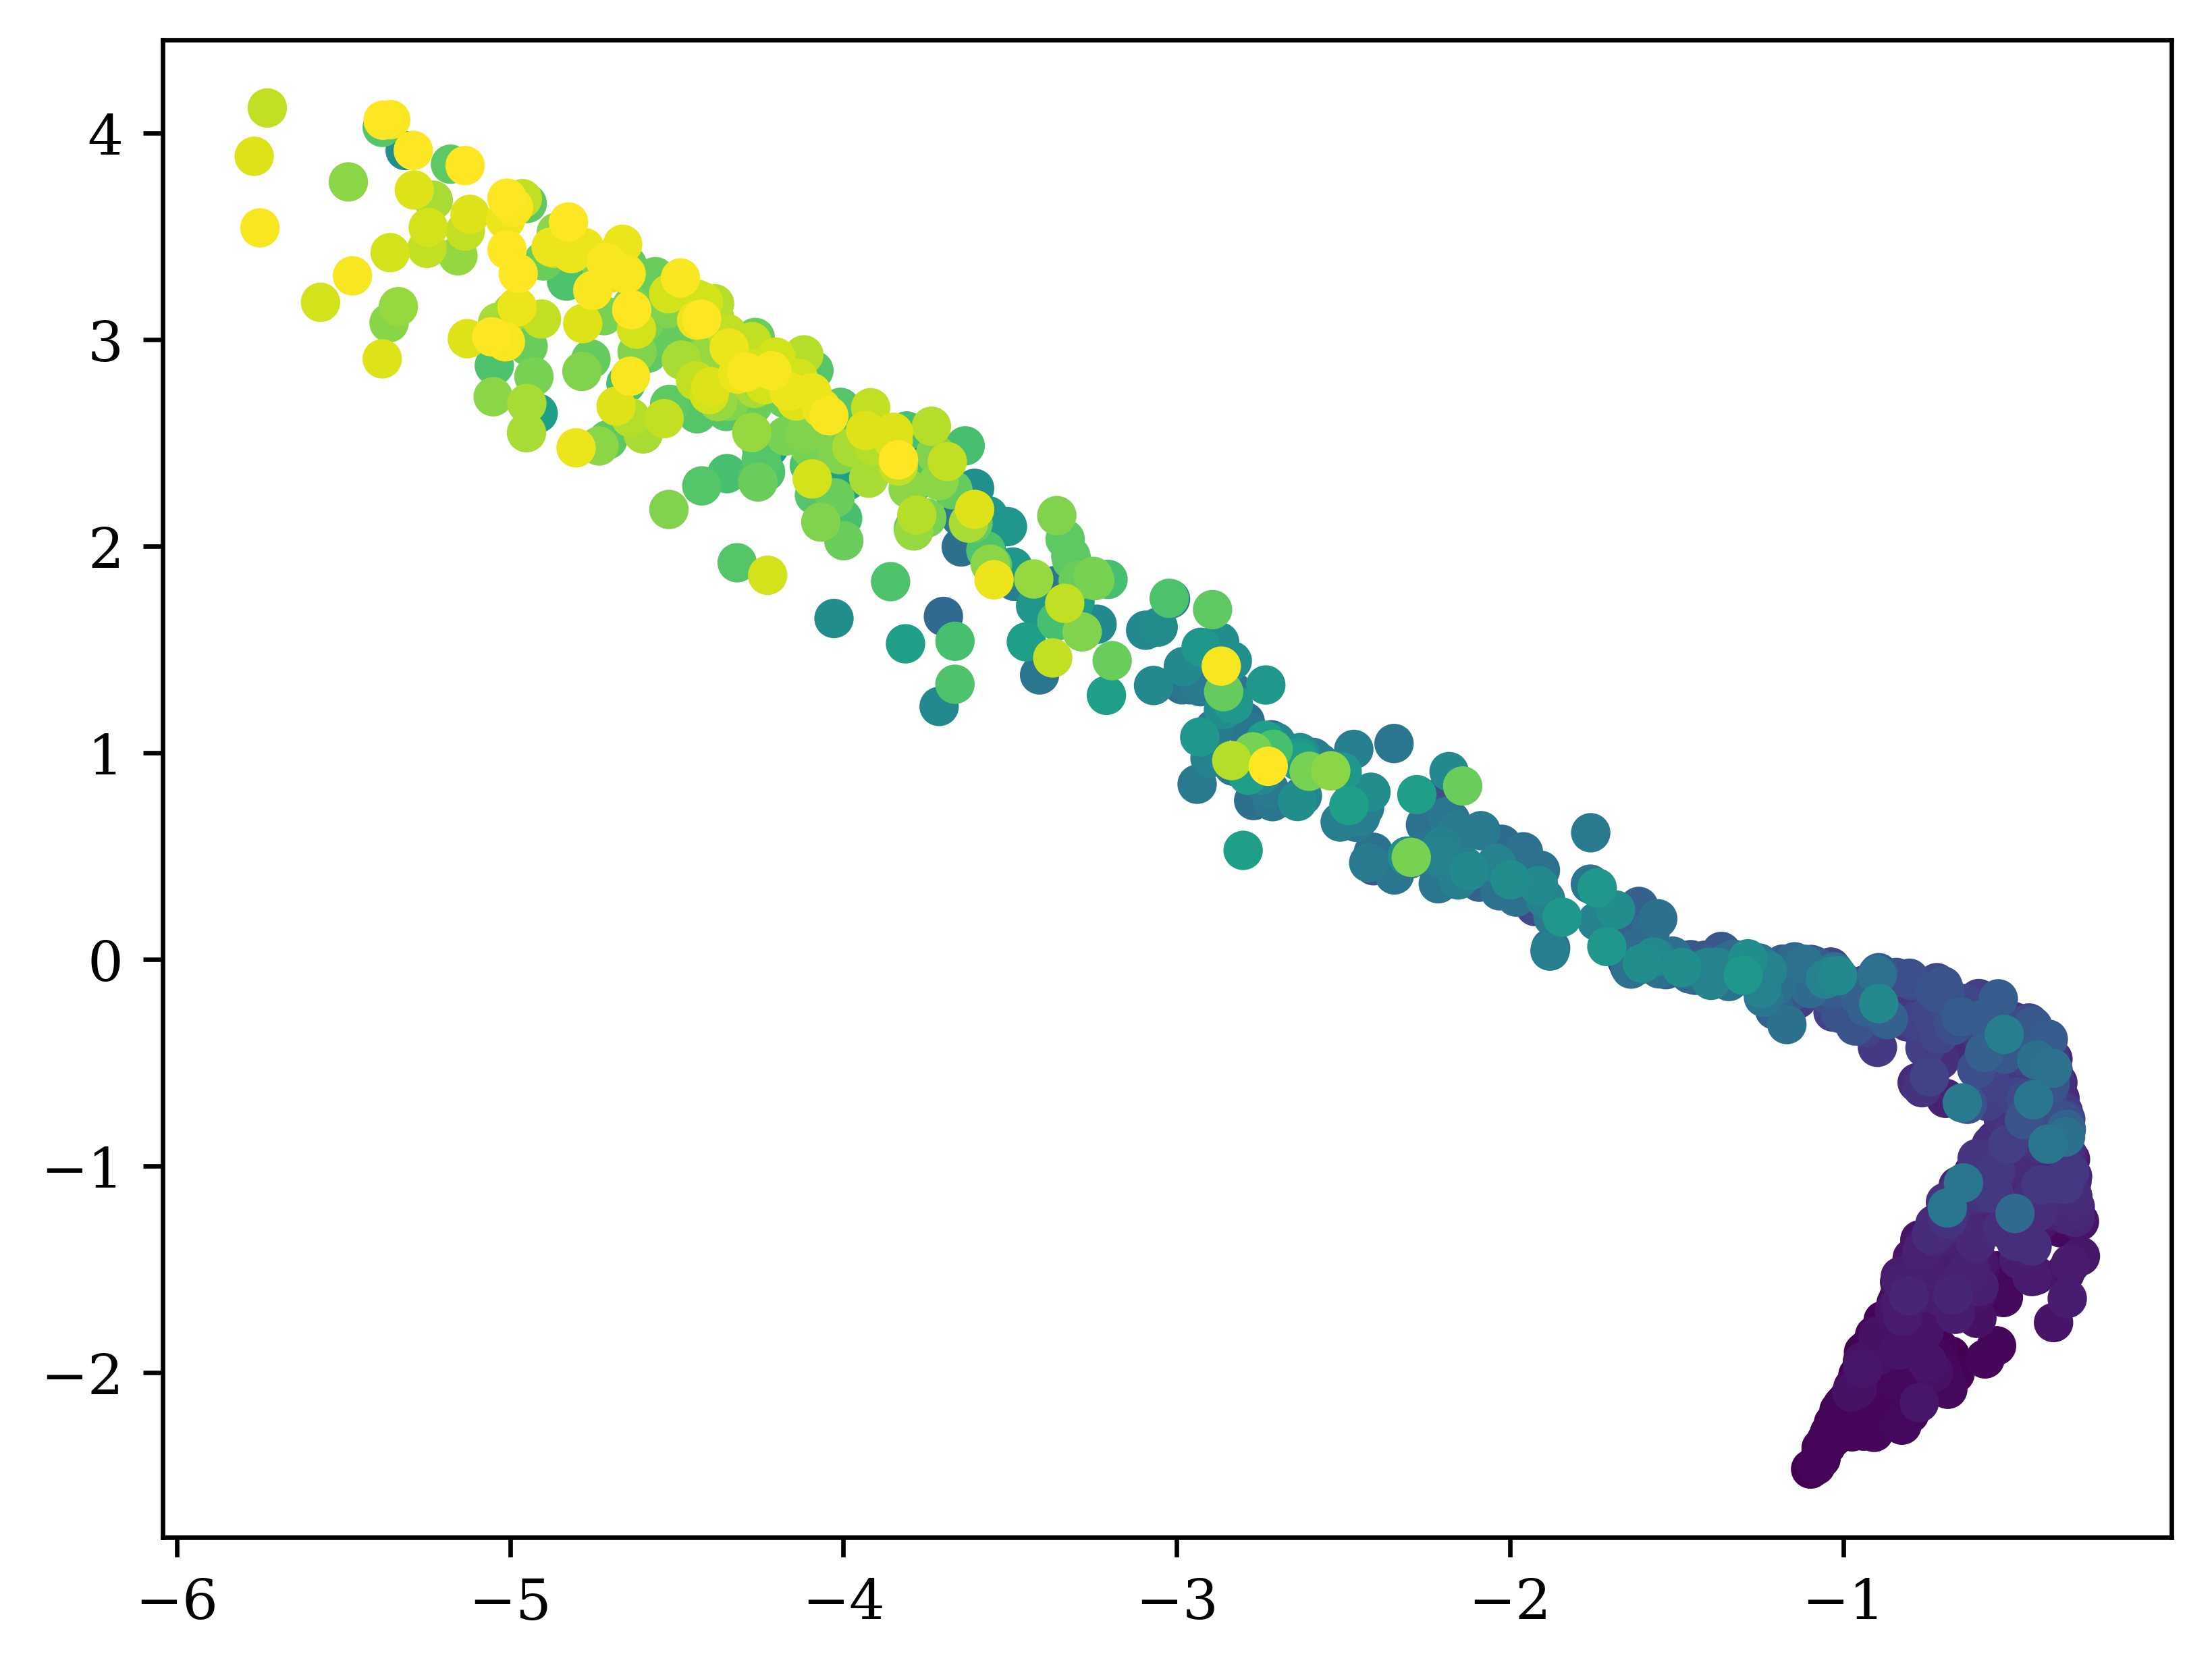

In [54]:
plt.scatter(*emb.T, c=df.index.get_level_values('age'))

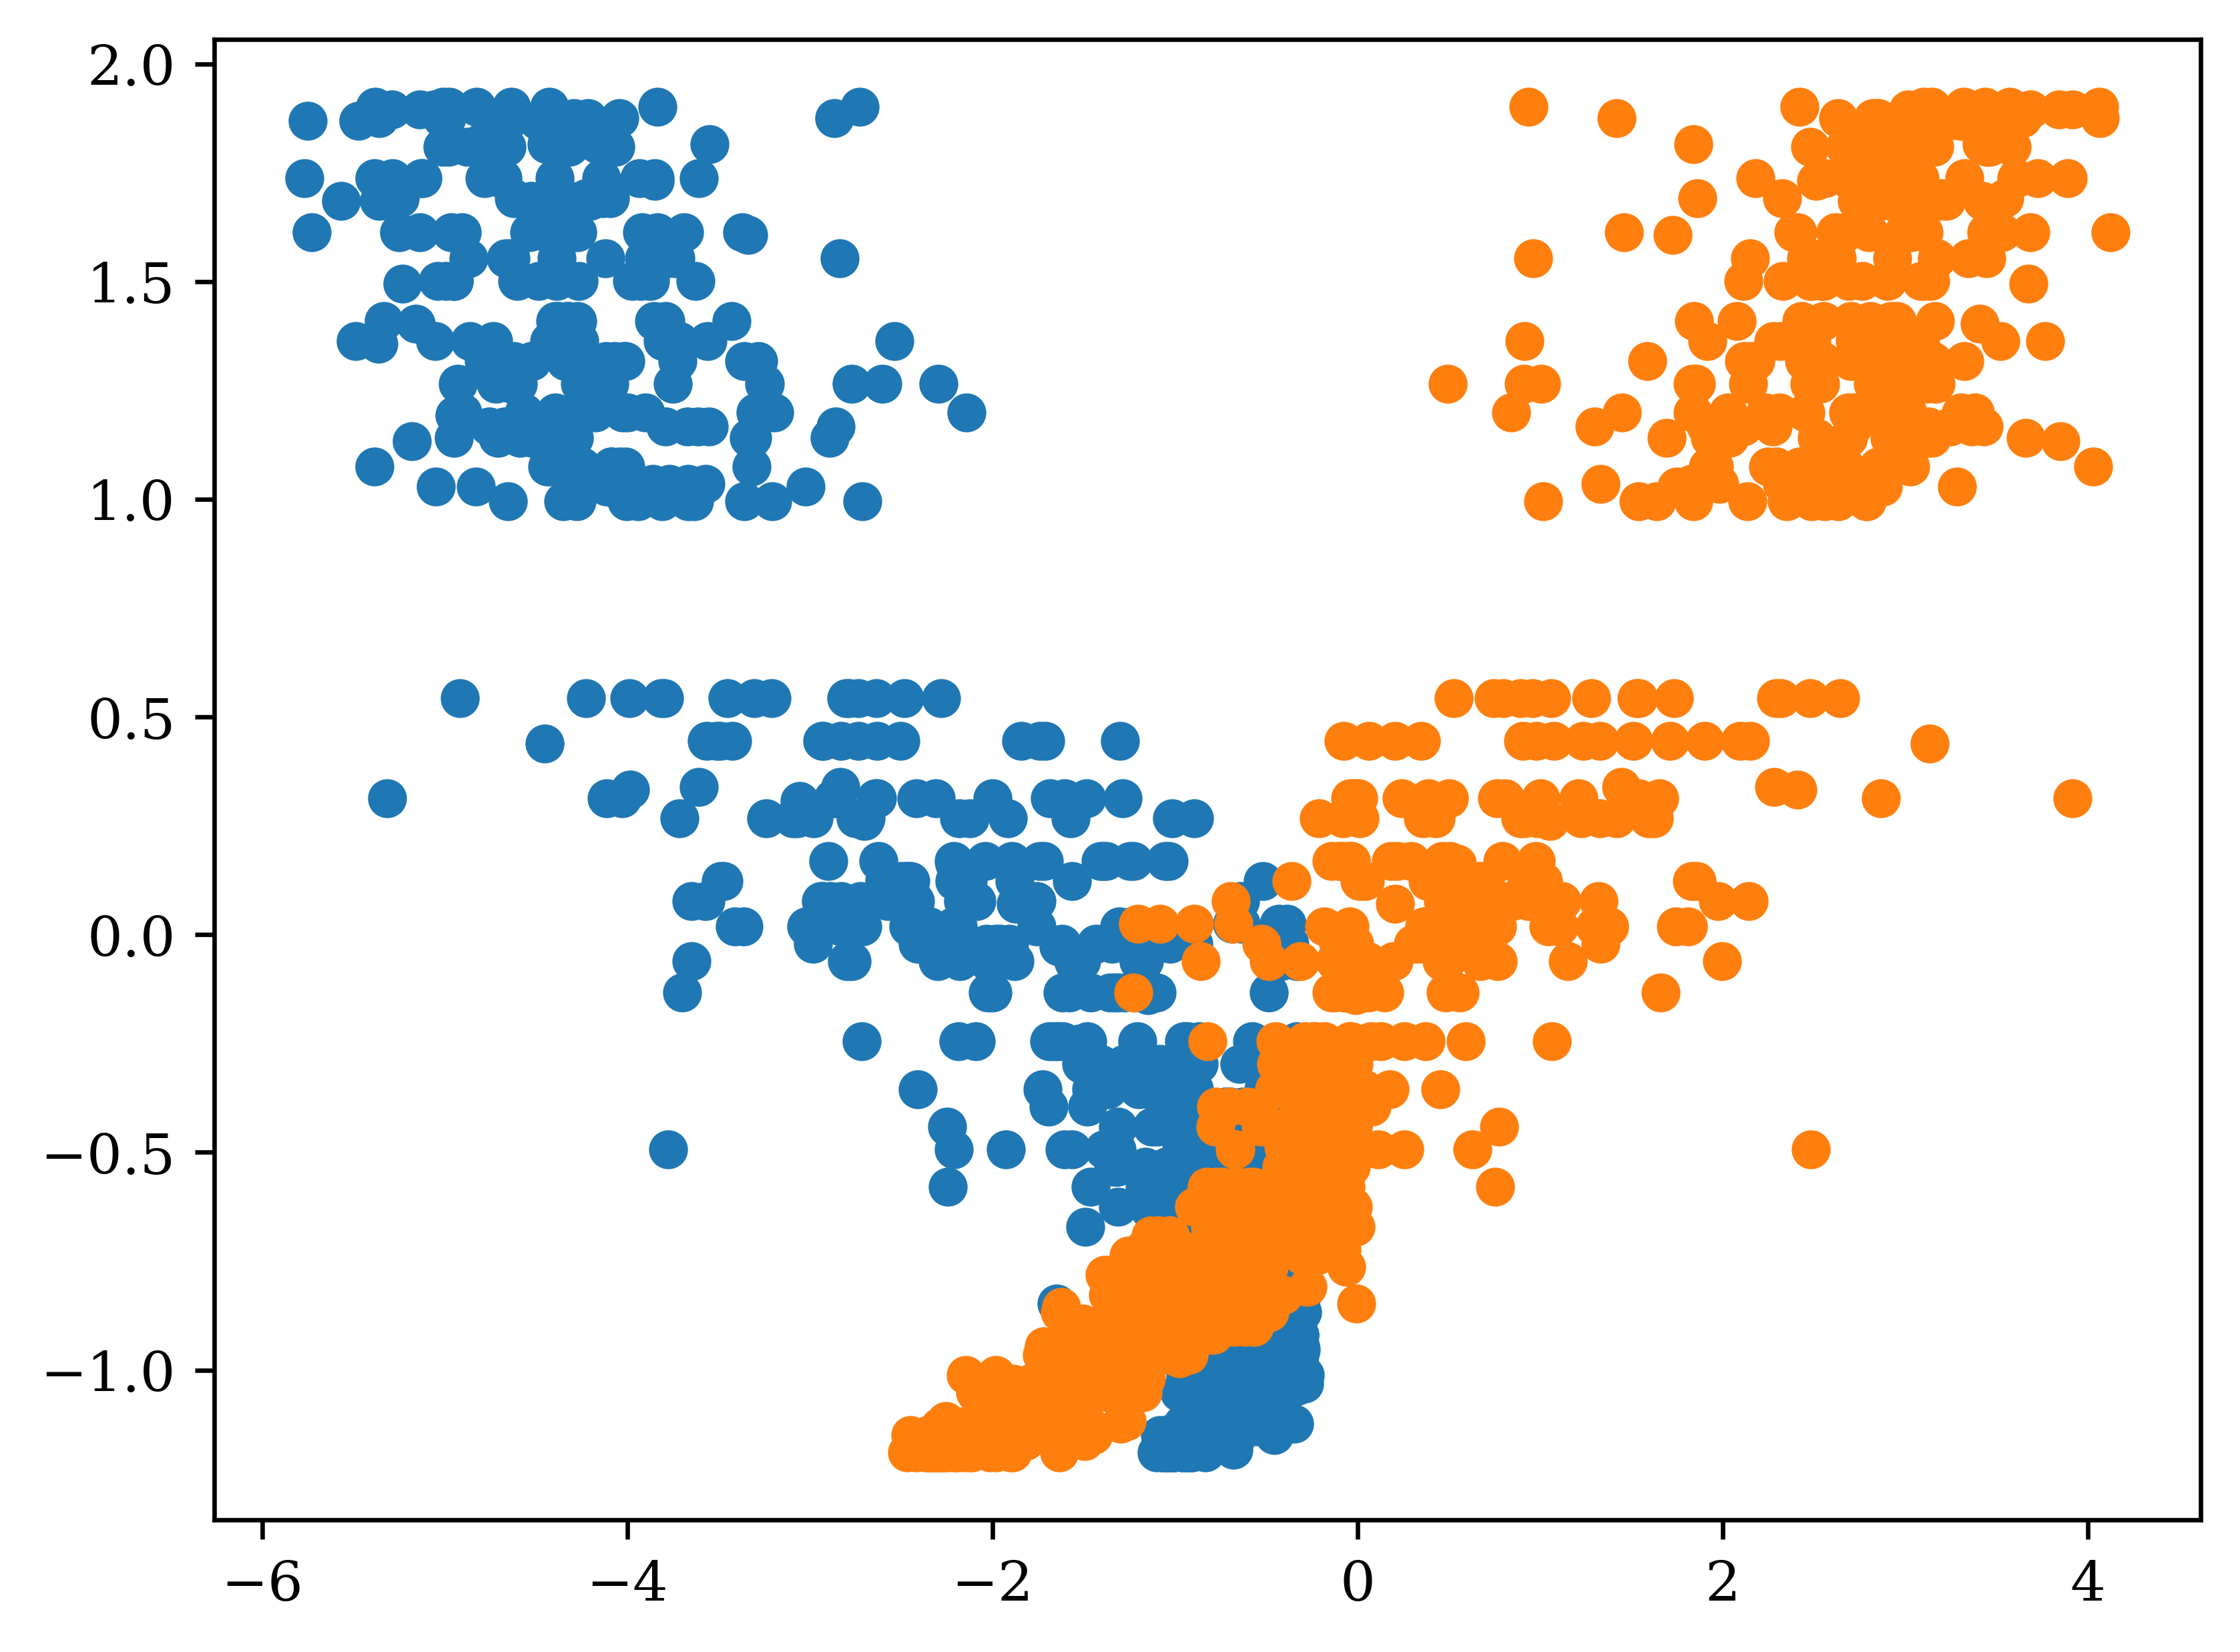

In [55]:
plt.scatter(emb[:, 0], in_df.index.get_level_values('age'))
plt.scatter(emb[:, 1], in_df.index.get_level_values('age'))

## Classifier version

In [17]:
mdl_type = "classifier"

n_mice = in_df.index.get_level_values("mouse_id").nunique()

betas = [0.01, 0.1, 0.2, 0.5, 0.9, 0.99]

classifier_output = {}
for beta in tqdm(betas):
    model = GuidedAE(
        len(in_df.columns),
        nn.GELU,
        [32, 16, 8, 4],
        latent_dim=2,
        mdl_type=mdl_type,
        n_classes=n_mice,
    )
    gae = LitGAE(model, beta, in_df, batch_size=64, mdl_type=mdl_type)

    trainer = pl.Trainer(
        max_epochs=75,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=False,
        precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
        enable_checkpointing=False,
        enable_progress_bar=False,
    )
    trainer.fit(gae)

    print(beta)
    out = trainer.validate(gae)
    classifier_output[beta] = out

  0%|          | 0/6 [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.01


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.2222222238779068     │
│         val_loss          │    2.0912716388702393     │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.21164020895957947    │
│         val_loss          │     2.089184045791626     │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.2


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.28042328357696533    │
│         val_loss          │    1.8189374208450317     │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │     0.30158731341362      │
│         val_loss          │    1.3547289371490479     │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.9


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.1746031790971756     │
│         val_loss          │    0.4744061529636383     │
└───────────────────────────┴───────────────────────────┘

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 5.1 K 
-----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=75` reached.
SLURM auto-requeueing enabled. Setting signal handlers.


0.99


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.12169311940670013    │
│         val_loss          │    0.27078545093536377    │
└───────────────────────────┴───────────────────────────┘

In [37]:
model = GuidedAE(
    len(in_df.columns),
    nn.GELU,
    [128, 64, 32, 16, 8, 8],
    latent_dim=2,
    mdl_type=mdl_type,
    n_classes=n_mice,
)
gae = LitGAE(model, 0.5, in_df, batch_size=64, mdl_type=mdl_type)

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=False,
    precision="16-mixed" if torch.cuda.is_available() else "bf16-mixed",
    enable_checkpointing=False,
    enable_progress_bar=True,
)
trainer.fit(gae)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GuidedAE | 36.6 K
-----------------------------------
36.6 K    Trainable params
0         Non-trainable params
36.6 K    Total params
0.146     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [38]:
trainer.validate(gae)

SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.35978835821151733    │
│         val_loss          │     5.078866481781006     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 5.078866481781006, 'acc': 0.35978835821151733}]

In [19]:
out = pd.DataFrame([x[0] for x in classifier_output.values()], index=list(classifier_output))

In [20]:
out

,val_loss,acc
0.01,2.091272,0.222222
0.10,2.089184,0.211640
0.20,1.818937,0.280423
0.50,1.354729,0.301587
0.90,0.474406,0.174603
0.99,0.270785,0.121693


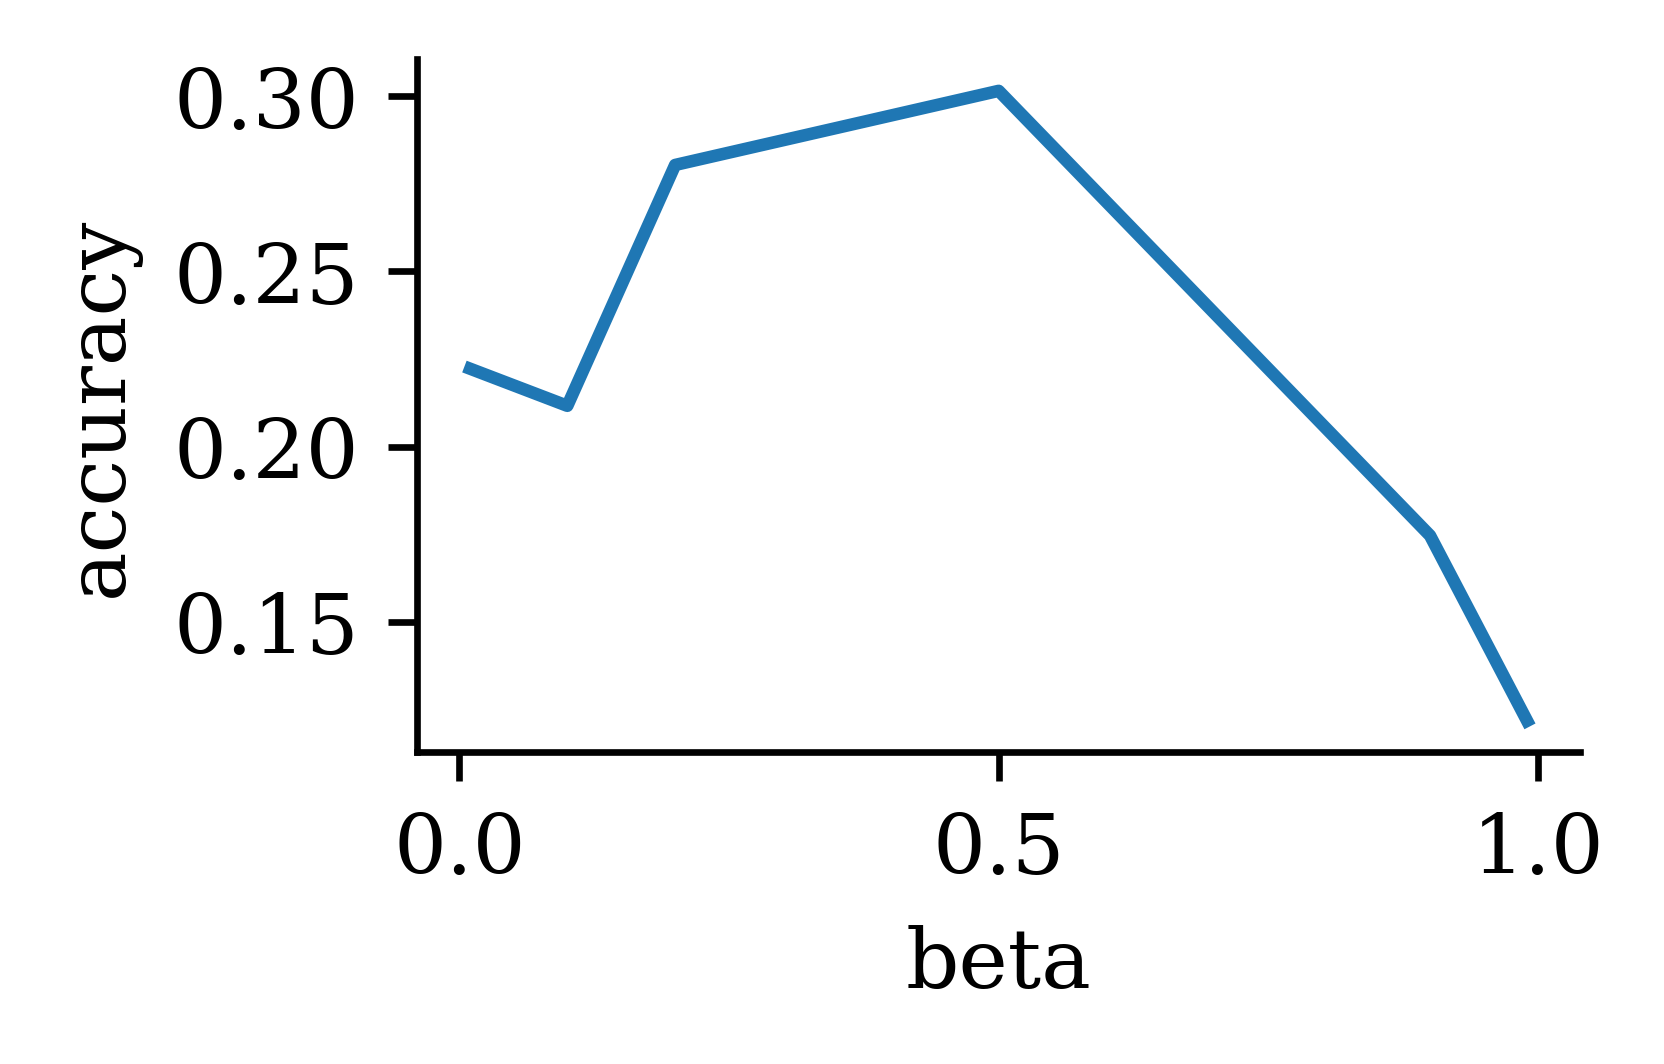

In [22]:
ax = out['acc'].plot(figsize=(2.5, 1.5))
ax.set(ylabel='accuracy', xlabel='beta')
sns.despine()

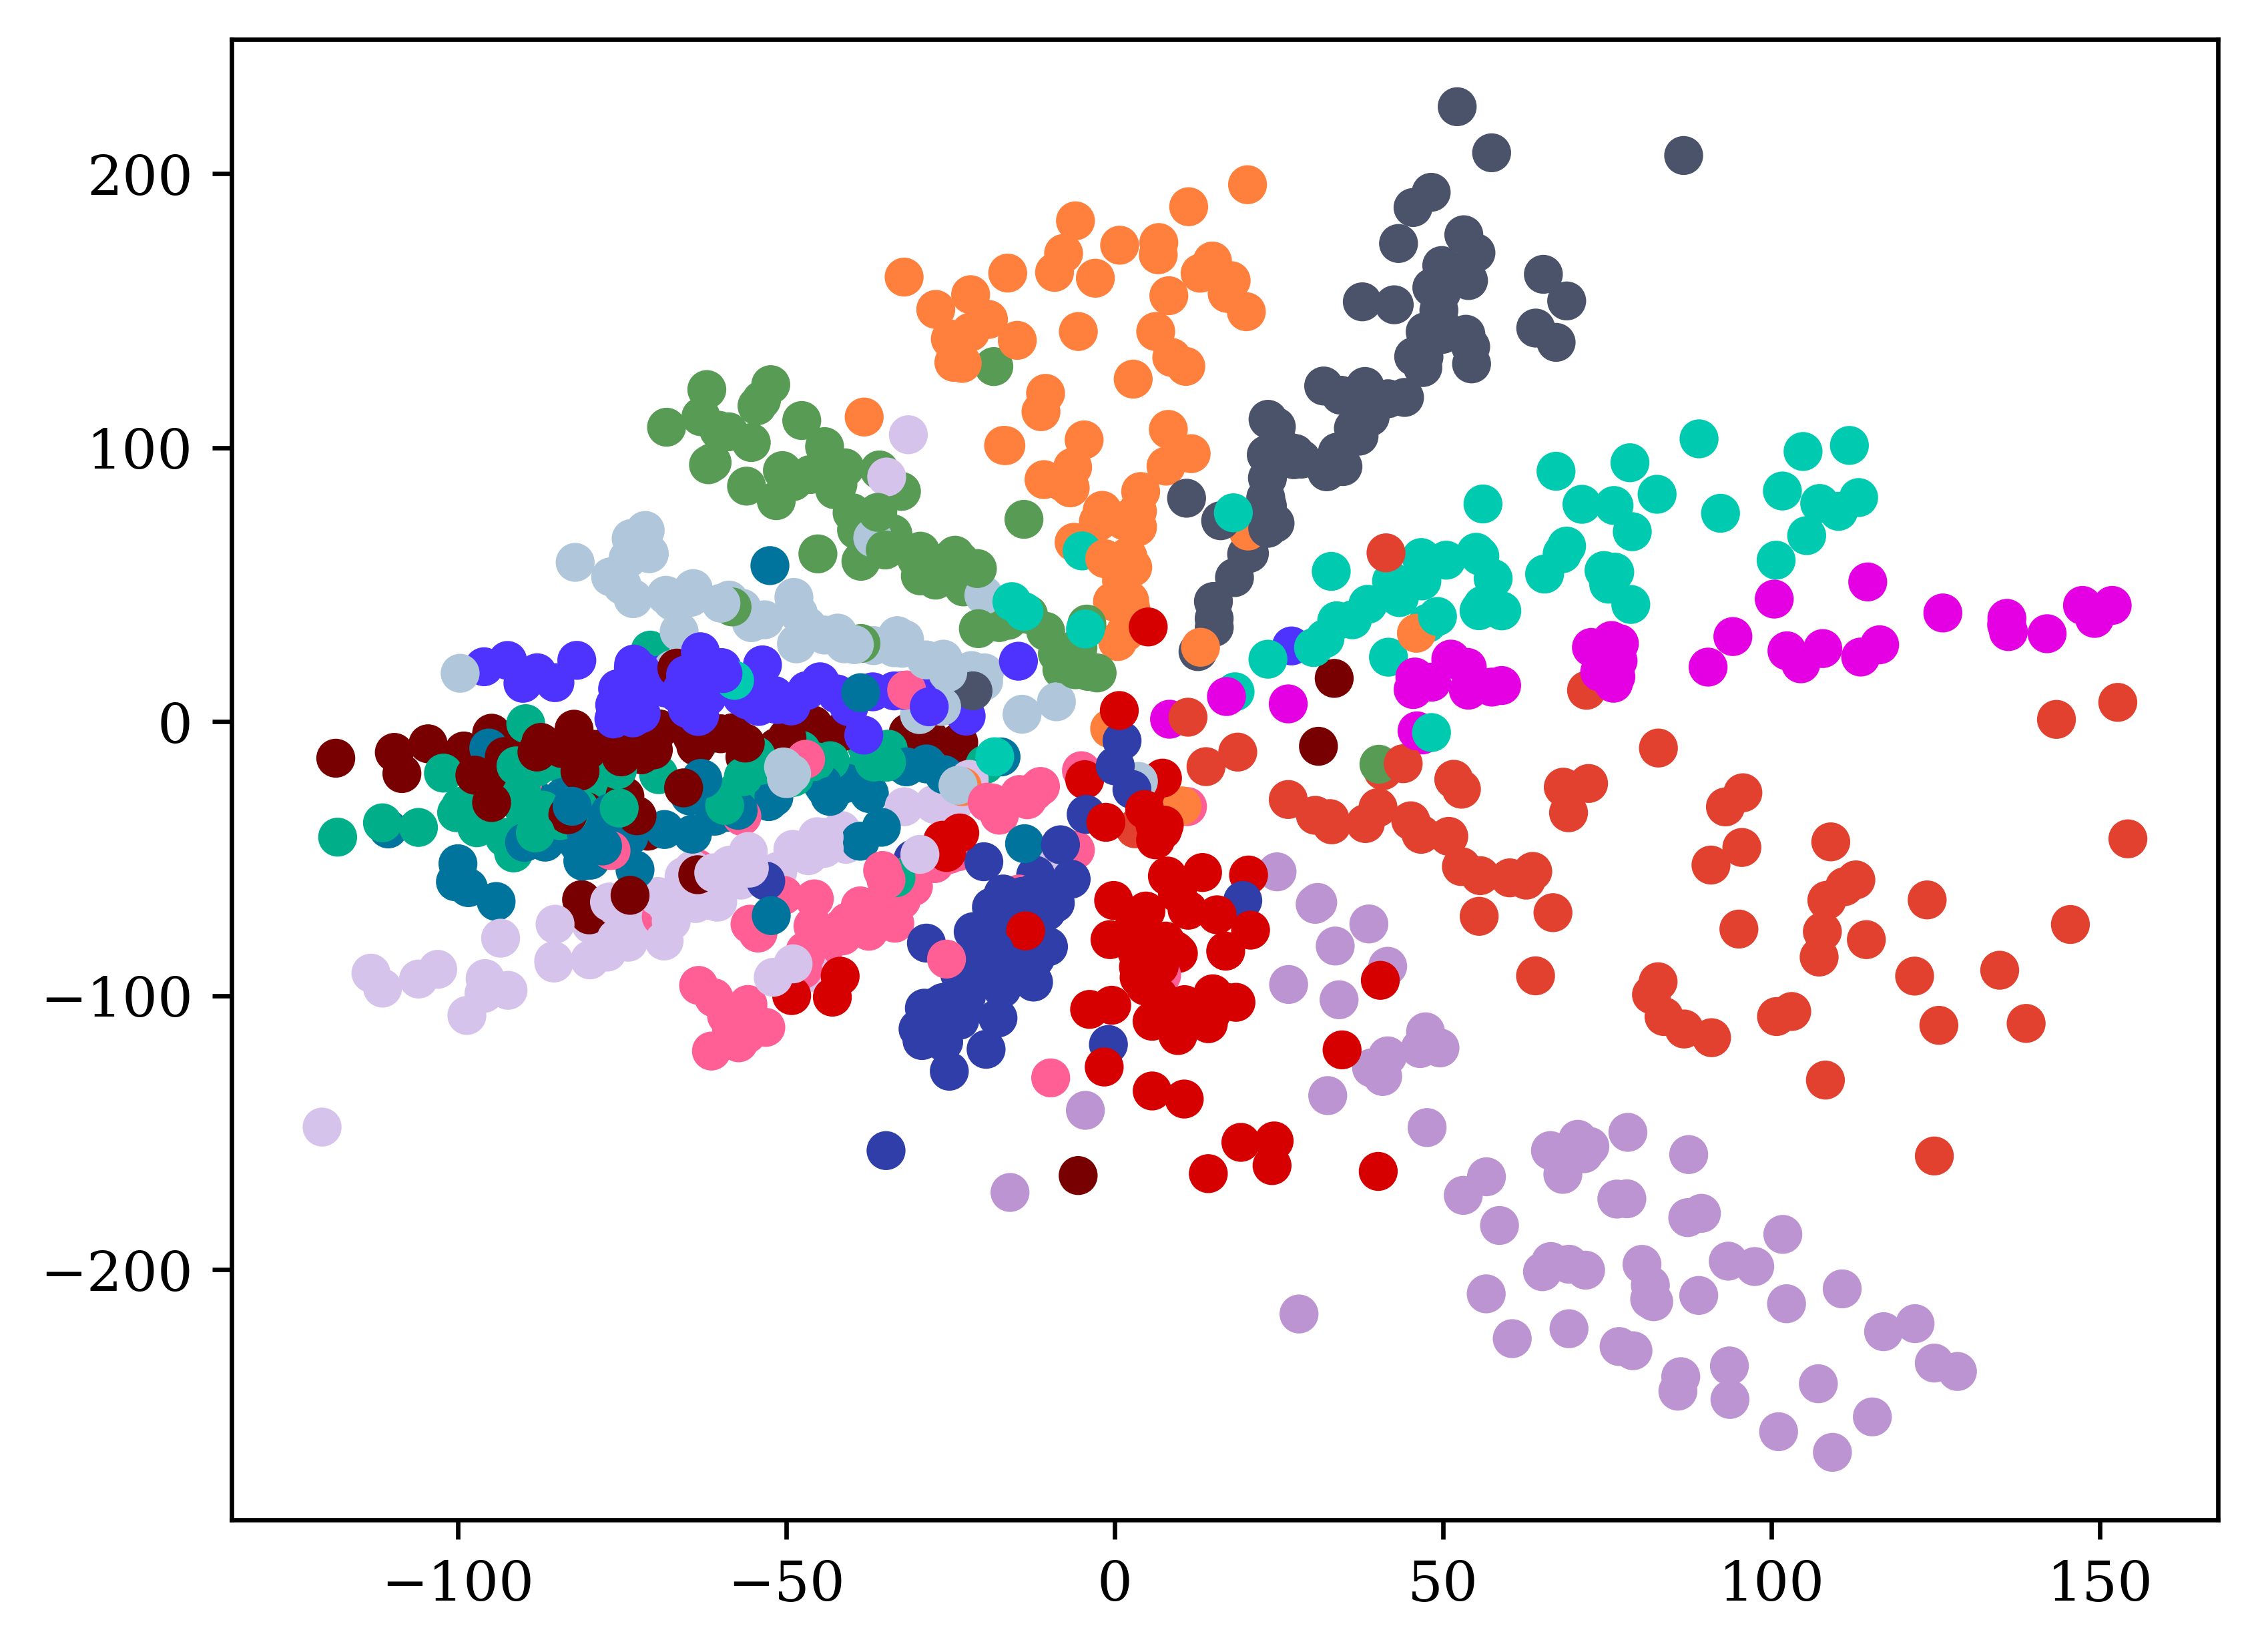

In [39]:
emb = model.transform(torch.tensor(in_df.to_numpy(), dtype=torch.float32)).detach().numpy()
enc = LabelEncoder().fit_transform(in_df.index.get_level_values('mouse_id'))
plt.scatter(*emb.T, c=enc, cmap=cc.cm.glasbey)

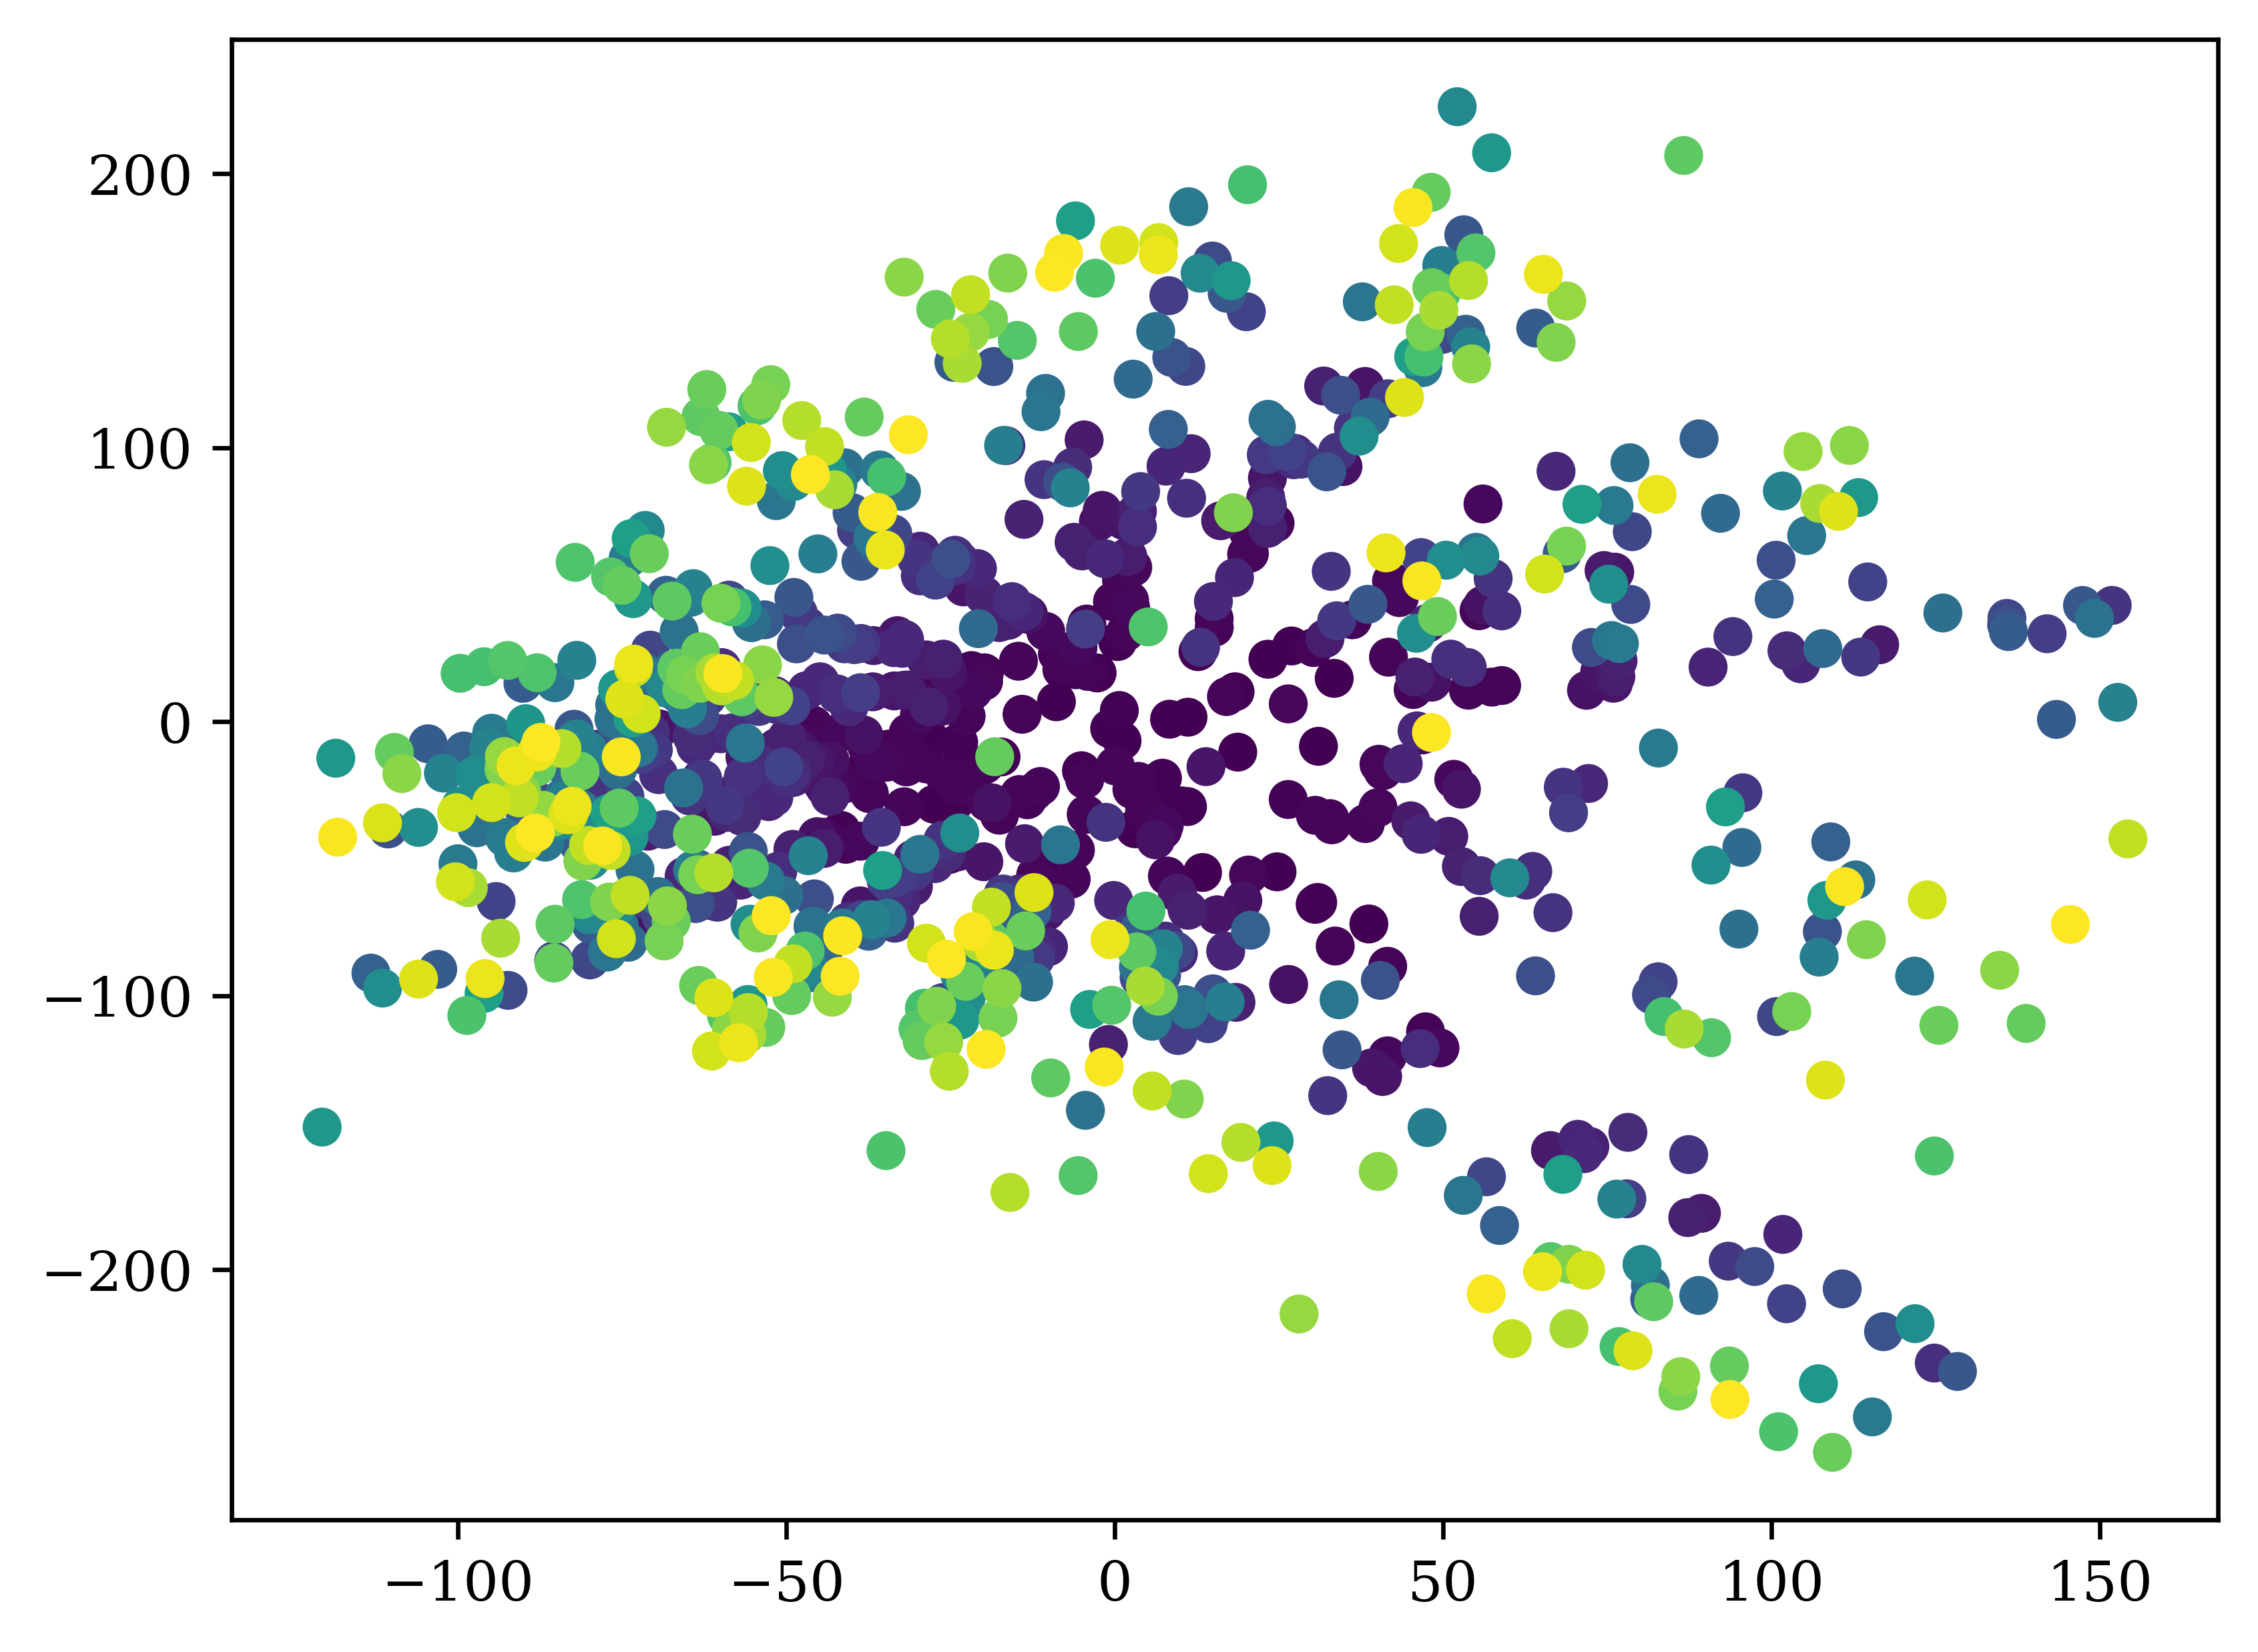

In [40]:
emb = model.transform(torch.tensor(in_df.to_numpy(), dtype=torch.float32)).detach().numpy()
plt.scatter(*emb.T, c=in_df.index.get_level_values('age'))